In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
import cv2
import io
from google.colab.patches import cv2_imshow

#COCO api
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

#Augmentations
! pip install --upgrade albumentations
import albumentations as A
import cv2

PyTorch Version:  1.7.0+cu101
Torchvision Version:  0.8.1+cu101
     |████████████████████████████████| 81kB 5.4MB/s 
     |████████████████████████████████| 952kB 16.8MB/s 
     |████████████████████████████████| 36.7MB 87kB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#train
dataDir='/content/gdrive/My Drive/Phase Project/COCO'
dataType='train2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
coco =COCO(annFile)
#val
dataDir='/content/gdrive/My Drive/Phase Project/COCO'
dataType2='val2017'
annFile2='{}/annotations/instances_{}.json'.format(dataDir,dataType2)
coco2 = COCO(annFile2)

loading annotations into memory...
Done (t=20.87s)
creating index...
index created!
loading annotations into memory...
Done (t=1.52s)
creating index...
index created!


'http://images.cocodataset.org/train2017/000000249668.jpg'

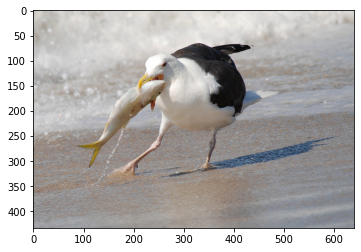

In [ ]:
catID = coco.getCatIds(catNms=['bird'])
imgIds = coco.getImgIds(catIds= catID )
img_id = imgIds[1603]
i = coco.loadImgs(img_id)[0]
img = io.imread(i['coco_url'])
plt.imshow(img)
i['coco_url']

In [ ]:
from torch.utils.data import Dataset

class COCODataset(Dataset):
  def __init__(self, coco, catNms, transform = None):
    self.coco = coco
    self.transform = transform
    self.catIds = coco.getCatIds(catNms=catNms)
    self.imgIds = coco.getImgIds(catIds= self.catIds )

  def __len__(self):
     return len(self.imgIds)


  def __getitem__(self, index):
      
      coco = self.coco
      imgIds = self.imgIds
      catIds = self.catIds
      img_id = imgIds[index]

      #image
      i = coco.loadImgs(img_id)[0]
      img = io.imread(i['coco_url'])

      #annotations
      annIds = coco.getAnnIds(imgIds=i['id'], catIds=self.catIds, iscrowd=None)
      coco_annotation = coco.loadAnns(annIds)
      num_objs = len(coco_annotation)
      boxes = []
      labels = []
      for i in range(num_objs):
          xmin = coco_annotation[i]["bbox"][0]
          ymin = coco_annotation[i]["bbox"][1]
          xmax = xmin + coco_annotation[i]["bbox"][2]
          ymax = ymin + coco_annotation[i]["bbox"][3]
          boxes.append([xmin, ymin, xmax, ymax])
          labels.append(coco_annotation[i]["category_id"])
      boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
      labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
      img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
      areas = []
      for i in range(num_objs):
          areas.append(coco_annotation[i]["area"])
      areas = torch.as_tensor(areas, dtype=torch.float32)

      #Annotations to dictionar

      my_annotation = {}
      my_annotation["boxes"] = boxes
      my_annotation["labels"] = labels
      my_annotation["image_id"] = img_id
      my_annotation["area"] = areas
      
      sample = (img, my_annotation)

      if self.transform:
         sample = self.transform(sample)
         
      return sample


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
        

    def __call__(self,sample):
        img , annotations = sample[0], sample[1]
        image = transforms.ToTensor()(img)
        sample = (image, sample[1])
        return sample

class Resize_Img_Bbox(object):

    def __call__(self, sample):
        img , myannotation = sample[0], sample[1]
        M = myannotation["boxes"].tolist()
        K = myannotation["labels"].tolist()
        print(K[0])
        L = myannotation["area"]
        aug = A.Compose([A.Resize(height=512, width=512),
                         ], bbox_params=A.BboxParams(format='pascal_voc', min_area = 512, label_fields=['class_labels', 'area']))
        result = aug(image=img, bboxes = M, class_labels = K, area = L)
        img = result['image']
        myannotation["boxes"] = result['bboxes']
        myannotation["labels"] = result['class_labels']
        myannotation["area"] = result['area']
        sample = (img, myannotation)
        return sample



In [ ]:
import PIL
from PIL.Image import BICUBIC
from PIL import Image

transform_train = transforms.Compose([Resize_Img_Bbox(),
                                      ToTensor(),    
                                      
                            
])

In [ ]:

cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush



In [ ]:
catNms = ['person', 'car', 'truck']
trainset = COCODataset(coco, catNms =catNms, transform = transform_train)
valset = COCODataset(coco2, catNms =catNms, transform = transform_train)
train = DataLoader(trainset, batch_size = 1, shuffle = True, num_workers = 2)
val = DataLoader(valset, batch_size = 1, shuffle = True, num_workers = 2)

In [ ]:
#exploring trainset
print(len(trainset))
print(len(valset))
catNms = catNms
class_dic = {}
for i in catNms:
    catId = coco.getCatIds(catNms=[i])
    class_dic[i] = catId[0]
print(class_dic)

2484
101
{'person': 1, 'car': 3, 'truck': 8}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1
{'boxes': [(372.456005859375, 276.0639973958333, 473.48798828125, 327.73333333333335), (120.18399658203126, 274.61334635416665, 183.84000244140626, 312.1599934895833), (326.552001953125, 295.22132161458336, 369.8239990234375, 314.816015625), (434.29599609375, 279.0293294270833, 454.9919921875, 304.8213216145833), (448.4240234375, 278.79466145833334, 475.664013671875, 299.7013346354167)], 'labels': [8, 8, 3, 3, 8], 'image_id': tensor([454565]), 'area': [tensor(3187.7627), tensor(1560.7350), tensor(556.0785), tensor(346.4656), tensor(406.9258)]}
(512, 512, 3)
5  boxes


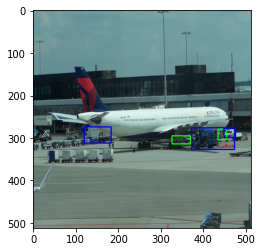

In [ ]:


img_, myannotation = trainset[1200]
print(myannotation)
img_ = np.array(img_).transpose((1,2,0))
plt.imshow(img_)
print(img_.shape)

img = img_.copy()
num_boxes = len(myannotation["labels"])  # The image has 16 bounding boxes pertaining to 3 object classes
print(num_boxes, ' boxes')
for i in range(0,num_boxes):
    if myannotation["labels"][i] == 1:
      [xmin,ymin,xmax,ymax] = myannotation["boxes"][i]
      cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255,0,0), 2)
    if myannotation["labels"][i] == 3:
      [xmin,ymin,xmax,ymax] = myannotation["boxes"][i]
      cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0,255,0), 2)
    if myannotation["labels"][i] == 8:
      [xmin,ymin,xmax,ymax] = myannotation["boxes"][i]
      cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0,0,255), 2)   
plt.imshow(img)

#Model- EfficientDet

In [ ]:
import warnings

warnings.filterwarnings("ignore")

class Train:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

In [ ]:
pip install effdet

In [ ]:
from effdet import  EfficientDet, get_efficientdet_config
from effdet.efficientdet import HeadNet
EfficientDet

effdet.efficientdet.EfficientDet

In [ ]:
config = get_efficientdet_config('efficientdet_d0')
config.num_classes = 3
config

{'name': 'efficientdet_d0', 'backbone_name': 'efficientnet_b0', 'backbone_args': {'drop_path_rate': 0.1}, 'image_size': [512, 512], 'num_classes': 3, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 4.0, 'pad_type': '', 'act_type': 'swish', 'norm_layer': None, 'norm_kwargs': {'eps': 0.001, 'momentum': 0.01}, 'box_class_repeats': 3, 'fpn_cell_repeats': 3, 'fpn_channels': 64, 'separable_conv': True, 'apply_bn_for_resampling': True, 'conv_after_downsample': False, 'conv_bn_relu_pattern': False, 'use_native_resize_op': False, 'pooling_type': None, 'redundant_bias': False, 'head_bn_level_first': False, 'fpn_name': None, 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'label_smoothing': 0.0, 'new_focal': False, 'jit_loss': False, 'delta': 0.1, 'box_loss_weight': 50.0, 'url': 'https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/efficientdet_d0-f3276ba8.pth'}

In [ ]:
model = EfficientDet(config, pretrained_backbone=True)
img_, myannotation = next(iter(train))
img_.shape

torch.Size([1, 3, 512, 512])

In [ ]:
model.eval()
K = myannotation["boxes"]
output = model(img_)


In [ ]:
output[0][1].shape

torch.Size([1, 27, 32, 32])

In [ ]:
output[1][0].shape

torch.Size([1, 36, 64, 64])

In [ ]:
output[1][1].shape

torch.Size([1, 36, 32, 32])

In [ ]:
model.class_net = HeadNet(config, num_outputs = config.num_classes)
model.class_net

HeadNet(
  (conv_rep): ModuleList(
    (0): SeparableConv2d(
      (conv_dw): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
      (conv_pw): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): SeparableConv2d(
      (conv_dw): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
      (conv_pw): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): SeparableConv2d(
      (conv_dw): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
      (conv_pw): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (bn_rep): ModuleList(
    (0): ModuleList(
      (0): Sequential(
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
      (2): Se

In [ ]:
config

{'name': 'efficientdet_d0', 'backbone_name': 'efficientnet_b0', 'backbone_args': {'drop_path_rate': 0.1}, 'image_size': [512, 512], 'num_classes': 3, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 4.0, 'pad_type': '', 'act_type': 'swish', 'norm_layer': None, 'norm_kwargs': {'eps': 0.001, 'momentum': 0.01}, 'box_class_repeats': 3, 'fpn_cell_repeats': 3, 'fpn_channels': 64, 'separable_conv': True, 'apply_bn_for_resampling': True, 'conv_after_downsample': False, 'conv_bn_relu_pattern': False, 'use_native_resize_op': False, 'pooling_type': None, 'redundant_bias': False, 'head_bn_level_first': False, 'fpn_name': None, 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'label_smoothing': 0.0, 'new_focal': False, 'jit_loss': False, 'delta': 0.1, 'box_loss_weight': 50.0, 'url': 'https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/efficientdet_d0-f3276ba8.pth'}

In [ ]:
best_acc = 0
def train_(model, train, test, optimizer, criterion1, criterion2, scheduler, device, epochs):
    loss_train_reg = []
    loss_train_pred = []
    loss_test_reg = []
    loss_test_pred = []
    for epoch in range(epochs):
        #train mode
        model.train()
        loss_reg_train = 0.0
        loss_class_train = 0.0
        total_loss_train = 0.0
        correct = 0
        total = 0
        for samples in train:
            inputs = samples['image']
            targets = samples['target']
            annotations = samples['annotations']
            inputs, targets, annotations = inputs.to(device), targets.to(device), annotations.to(device)
            total += targets.size(0)
            features = features_extractor(inputs)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
              bbox, clss = model(features)
              _, preds = torch.max(clss,1)
              loss1 = criterion1(clss, targets)  
              loss2 = criterion2(bbox, annotations).sum(1).mean()
              loss = loss1 + loss2
              loss.backward()
              optimizer.step()
            loss_reg_train = loss_reg_train + loss2.item() * inputs.size(0)
            loss_class_train = loss_class_train + loss1.item()* inputs.size(0)
            total_loss_train = total_loss_train + (loss2.item() + loss1.item())* inputs.size(0)
            correct = correct + torch.sum(preds == targets.data)
        scheduler.step() 
        print('Epoch: [%d/%d] Train Regression Loss: %.3f, Train Prediction Loss: %.3f , Overall loss : %.3f| Train Acc: %.3f%% (%d/%d)'
          %(epoch, epochs, torch.true_divide(loss_reg_train, len(trainset)), torch.true_divide(loss_class_train, len(trainset)), torch.true_divide(total_loss_train, len(trainset)), 100* torch.true_divide(correct, total) , correct, total))
        loss_train_reg.append(  torch.true_divide(loss_reg_train, len(trainset)))
        loss_train_pred.append(  torch.true_divide(loss_class_train, len(trainset)))
        loss_train_ = (loss_train_reg, loss_train_pred)

        model.eval()
        loss_val_reg = 0.0
        loss_val_class = 0.0
        overall_loss = 0.0
        corr = 0
        tot = 0
        global best_acc
        for samples in test:
            inputs = samples['image']
            targets = samples['target']
            annotations = samples['annotations']
            inputs, targets, annotations = inputs.to(device), targets.to(device), annotations.to(device)
            tot += targets.size(0)
            features = features_extractor(inputs)
            with torch.no_grad():
              bbox1, clss1  = model(features)
              _, pred = torch.max(clss1,1)
              Loss1 = criterion1(clss1, targets)
              Loss2 = criterion2(bbox1, annotations).sum(1).mean()
            loss_val_reg = loss_val_reg + Loss2.item() * inputs.size(0)
            loss_val_class = loss_val_class + Loss1.item()* inputs.size(0)
            overall_loss = overall_loss + (Loss2.item() + Loss1.item())* inputs.size(0)
            corr = corr + torch.sum(pred == targets.data )

        print('Epoch: [%d/%d] Test Regression Loss: %.3f, Test Prediction Loss: %.3f , Overall loss : %.3f| Val Acc: %.3f%% (%d/%d)'
          %(epoch, epochs, torch.true_divide(loss_val_reg, len(testset)),torch.true_divide(loss_val_class, len(testset)),torch.true_divide(overall_loss, len(testset)), 100* torch.true_divide(corr,tot) , corr, tot))
        loss_test_reg.append(torch.true_divide(loss_val_reg,len(testset) ))
        loss_test_pred.append(torch.true_divide(loss_val_class,len(testset)))
        loss_test_ = (loss_test_reg, loss_test_pred)


        acc = 100* torch.true_divide(corr,tot)
        if acc > best_acc:
           print('Saving the model..')
           state = {
             'model': model.state_dict(),
             'acc': acc,
             'epoch': epoch,
              }
           if not os.path.isdir('checkpoint'):
                  os.mkdir('checkpoint')
                  torch.save(state, './checkpoint/ckpt.pth')
           best_acc = acc

    return loss_train_, loss_test_    